 - Min Frame Count: 25

In [136]:
from pathlib import Path
from typing import Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# from pytorchvideo.data import labeled_video_dataset, make_clip_sampler
# from pytorchvideo.transforms import (
#     ApplyTransformToKey,
#     Normalize,
#     Permute,
#     RandomShortSideScale,
#     UniformTemporalSubsample,
# )
from torch.utils.data import Dataset

import utils

# from torchvision.transforms import (
#     Compose,
#     Lambda,
#     RandomCrop,
#     RandomHorizontalFlip,
#     Resize,
# )
# from torchvision.transforms.functional
# from torchvision.transforms._transforms_video import CenterCropVideo, NormalizeVideo

### Convert the dataset 

```text
 CricShot10/
     train/
         flick/
             flick_0001.avi
             flick_0002.avi
             ...
        
```

In [137]:
# Global File Paths
ZIP_FILES_PATH = "data"
DATASET_NAME = "CricShot10"
DATASET_ROOT_PATH = "CricShot10/"
TO_DIR = "dataset"

In [138]:
TRAIN_SET_RATIO = 0.8
TEST_SET_RATIO = 1 - TRAIN_SET_RATIO

In [139]:
N_FRAMES = 16

In [93]:
# Extracting all files
utils.unzip_files(ZIP_FILES_PATH, DATASET_NAME)

Creating directory: CricShot10
Unzipping all the files: 
Unzipping: cover-20250328T152434Z-001.zip
Unzipping: defense-20250328T152432Z-001.zip
Unzipping: flick-20250328T152430Z-001.zip
Unzipping: hook-20250328T152430Z-001.zip
Unzipping: late_cut-20250328T152307Z-001.zip
Unzipping: lofted-20250328T152550Z-001.zip
Unzipping: pull-20250328T152305Z-001.zip
Unzipping: square_cut-20250328T152247Z-001.zip
Unzipping: straight-20250328T152224Z-001.zip
Unzipping: sweep-20250328T152202Z-001.zip
All files unzipped to: `C:\Users\Vaibhav Rastogi\Documents\projects\CricShot10`


In [95]:
samples_per_class = min(
    (
        len(list(path.glob("*.avi")))
        for path in Path(DATASET_ROOT_PATH).iterdir()
        if path.is_dir()
    )
)
print("Minimum Number of samples per class taken:", samples_per_class)

Minimum Number of samples per class taken: 179


In [97]:
# Setup the directory structure with defined train and test directories
utils.setup_dataset_structure(
    from_dir=DATASET_ROOT_PATH,
    to_dir=TO_DIR,
    train_ratio=TRAIN_SET_RATIO,
    samples_per_class=samples_per_class,
)

In [98]:
# Define train and test directories
root_dir = Path(TO_DIR)
train_dir = root_dir / "train"
test_dir = root_dir / "test"

In [99]:
train_paths = list(train_dir.glob("*/*.avi"))
test_paths = list(test_dir.glob("*/*.avi"))
print("No. of video files in training set:", len(train_paths))
print("No. of video files in testing set:", len(test_paths))

No. of video files in training set: 1430
No. of video files in testing set: 360


In [100]:
# Get all the classes in the dataset
class_names, classes_to_idx = utils.get_classes(train_dir)
print("All Classes in dataset:", class_names)

All Classes in dataset: ['cover', 'defense', 'flick', 'hook', 'late_cut', 'lofted', 'pull', 'square_cut', 'straight', 'sweep']


In [101]:
# train_dataset = [
#     (name, classes_to_idx["_".join(train_set[idx].name.split("_")[:-1])])
#     for idx, name in enumerate(train_set)
# ]

# test_dataset = [
#     (name, classes_to_idx["_".join(test_set[idx].name.split("_")[:-1])])
#     for idx, name in enumerate(test_set)
# ]

In [140]:
class CricShot10(torch.utils.data.Dataset):
    def __init__(
        self,
        target_dir: str,
        transform=None,
        n_frames: int = 16,
        target_size: Tuple[int, int] = (224, 224),
    ):
        self.target_dir = target_dir
        self.paths = list(target_dir.glob("*/*.avi"))

        self.transform = transform
        self.n_frames = n_frames
        self.target_size = target_size
        self.class_names, self.class_to_idx = utils.get_classes(target_dir)

    def __len__(self):
        return len(self.paths)

    def load_video(self, idx: int) -> torch.Tensor:
        video_path = str(self.paths[idx])

        cap = cv2.VideoCapture(video_path)

        frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

        indices = np.linspace(0, frame_count - 1, self.n_frames, dtype="int")

        frames = []
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()

            if not ret:
                last_frame = (
                    frames[-1]
                    if frames
                    else np.zeros(
                        (self.target_size[0], self.target_size[1], 3), dtype=np.uint8
                    )
                )
                frames.append(last_frame)
                continue

            frame = cv2.resize(frame, self.target_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        cap.release()

        if len(frames) < self.n_frames:
            # Pad with copies of the last frame
            last_frame = (
                frames[-1]
                if frames
                else np.zeros(
                    (self.target_size[0], self.target_size[1], 3), dtype=np.uint8
                )
            )
            frames.extend([last_frame] * (self.n_frames - len(frames)))

        frames = torch.from_numpy(np.array(frames))
        return frames

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        video = self.load_video(idx)
        class_name = "_".join(self.paths[idx].name.split("_")[:-1])
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(video), class_idx
        return video, class_idx

In [144]:
train_dataset = CricShot10(
    train_dir,
)

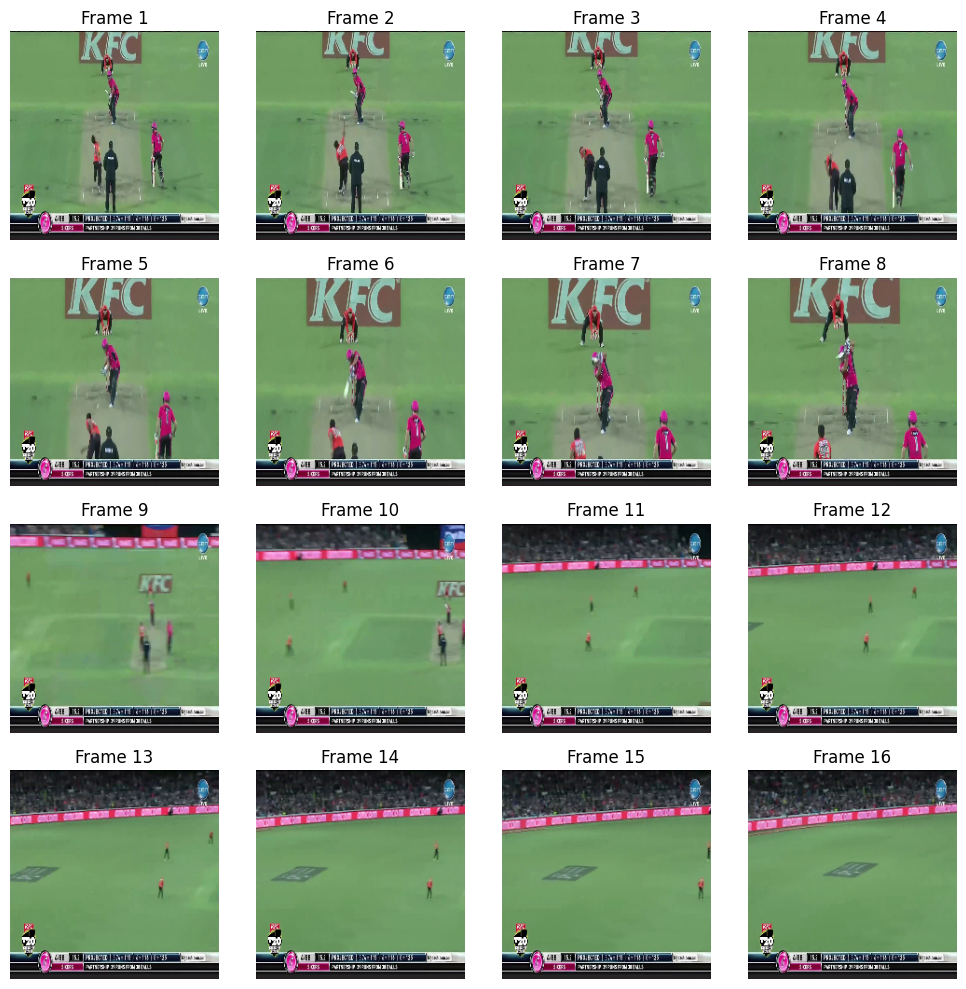

In [179]:
video, class_idx = train_dataset[0]
figure = plt.figure(figsize=(10, 10))
nrows, ncols = 4, 4
for idx in range(1, nrows * ncols + 1):
    figure.add_subplot(nrows, ncols, idx)
    plt.title(f"Frame {idx}")
    plt.imshow(video[idx - 1])
    plt.axis(False)
plt.tight_layout()

In [153]:
video.shape

torch.Size([16, 224, 224, 3])

In [168]:
train_dataset[1][1]

0

In [114]:
a.shape


torch.Size([16, 224, 224, 3])

In [62]:
# l = []
# for path in train_paths:
#     cap = cv2.VideoCapture(path)
#     fps = cap.get(cv2.CAP_PROP_FPS)
#     l.append(fps)

In [63]:
# 25000 / sum(l)

In [64]:
# min(l)

In [65]:
# max(l)

In [66]:
# l = np.array(l)

In [67]:
# a, b = np.unique(l, return_counts=True)

In [68]:
# a = a.reshape((-1, 1))
# b = b.reshape((-1, 1))

In [69]:
# d = np.concatenate((a, b), axis = 1)

In [70]:
# df = pd.DataFrame(d, columns=["Unique FPS", "Number of Videos"])

In [71]:
# df

In [75]:
indices = np.linspace(0, 50 - 1, 16, dtype=int)

In [76]:
indices

array([ 0,  3,  6,  9, 13, 16, 19, 22, 26, 29, 32, 35, 39, 42, 45, 49])